# Case Study #1 Danny's Diner

The following are my solutions to the Case Study 1 Danny's Diner questions in 
[Danny Ma's Serious SQL course](https://www.datawithdanny.com/ "Data With Danny")
<br/>
<br/>
Danny has shared with you 3 key datasets for this case study :
[Data Set](https://github.com/Shailesh-python/Case_Study_1_Dannys_Diner/blob/main/Data%20And%20Tables)
<br/>
- `sales`

- `menu`

- `members`

In [336]:
import pandas as pd
import pyodbc
from pandas.tseries.offsets import DateOffset
from datetime import timedelta
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [150]:
import pyodbc as py
import pandas as pd

conn = py.connect(
    "DRIVER={SQL Server};SERVER=SHAILESH-PC\SQLEXPRESS;DATABASE=DannyMa;"
)

df_sales = pd.read_sql_query('select * from dannys_diner.sales',conn)
df_members = pd.read_sql_query('select * from dannys_diner.members',conn)
df_menu = pd.read_sql_query('select * from dannys_diner.menu',conn)

conn.close()

In [3]:
df_sales.head()

,customer_id,order_date,product_id
0,A,2021-01-01,1
1,A,2021-01-01,2
2,A,2021-01-07,2
3,A,2021-01-10,3
4,A,2021-01-11,3


In [4]:
df_members.head()

,customer_id,join_date
0,A,2021-01-07
1,B,2021-01-09


In [5]:
df_menu.head()

,product_id,product_name,price
0,1,sushi,10
1,2,curry,15
2,3,ramen,12


## Case Study Questions: 

### 1. What is the total amount each customer spent at the restaurant?

In [339]:
total_amount = df_sales.merge(df_menu,on='product_id',how='left').groupby(['customer_id']).price.sum().to_frame()
total_amount

,price
customer_id,
A,76
B,74
C,36


### 2. How many days has each customer visited the restaurant?

In [7]:
df_sales[['customer_id','order_date']].drop_duplicates().groupby('customer_id').customer_id.count()

customer_id
A    4
B    6
C    2
Name: customer_id, dtype: int64

### 3. What was the first item(s) from the menu purchased by each customer?

In [8]:
# Apply left join
# Sort the dataframe
df_merged = df_sales.merge(df_menu, on='product_id', how='left').sort_values(by='order_date')

df_merged['order_date']=pd.to_datetime(df_merged['order_date'])
# Apply and Add a column for Rank
df_merged['Rank'] = df_merged.groupby('customer_id').order_date.rank(method='first')
# Filter Rank == 1
df_merged = df_merged[['customer_id','product_name','Rank']][df_merged.Rank==1]

df_merged

,customer_id,product_name,Rank
0,A,sushi,1.0
6,B,curry,1.0
12,C,ramen,1.0


### 4. What is the most purchased item on the menu and how many times was it purchased by all customers?

In [9]:
df_mostpurchased = pd.DataFrame()
df_mostpurchased = df_sales.merge(df_menu, on='product_id', how='left')[['product_name']].groupby('product_name').product_name.count()

In [10]:
df_mostpurchased

product_name
curry    4
ramen    8
sushi    3
Name: product_name, dtype: int64

### 5. Which item(s) was the most popular for each customer?

In [68]:
df = df_sales.merge(df_menu, on = 'product_id', how = 'left')

In [69]:
df.head()

,customer_id,order_date,product_id,product_name,price
0,A,2021-01-01,1,sushi,10
1,A,2021-01-01,2,curry,15
2,A,2021-01-07,2,curry,15
3,A,2021-01-10,3,ramen,12
4,A,2021-01-11,3,ramen,12


In [70]:
df = df.groupby(['customer_id','product_name']).product_name.count().to_frame()
df

product_name
customer_id product_name              
A           curry                    2
            ramen                    3
            sushi                    1
B           curry                    2
            ramen                    2
            sushi                    2
C           ramen                    3

### 6. Which item was purchased first by the customer after they became a member and what date was it? (including the date they joined)?

In [75]:
df = df_sales.merge(df_menu, on = 'product_id', how = 'left')
df = df.merge(df_members, on = 'customer_id', how = 'left')

In [80]:
df['order_date']=pd.to_datetime(df['order_date'])

In [81]:
df['join_date']=pd.to_datetime(df['join_date'])

In [87]:
df=df[df.order_date>=df.join_date].sort_values(by='order_date')

In [95]:
df['Rank'] = df.groupby(['customer_id'])['order_date'].rank(method='dense')

In [98]:
df[df.Rank==1]

,customer_id,order_date,product_id,product_name,price,join_date,Rank
2,A,2021-01-07,2,curry,15,2021-01-07,1.0
9,B,2021-01-11,1,sushi,10,2021-01-09,1.0


### 7. Which menu item(s) was purchased just before the customer became a member and when?
This is very similar to question 6 previously but now the record orders should be reversed using the window functions.

In [99]:
df = df_sales.merge(df_menu, on = 'product_id', how = 'left')
df = df.merge(df_members, on = 'customer_id', how = 'left')
df['order_date']=pd.to_datetime(df['order_date'])
df['join_date']=pd.to_datetime(df['join_date'])

In [100]:
df=df[df.order_date<df.join_date].sort_values(by='order_date')

In [104]:
df['Rank'] = df.groupby(['customer_id'])['order_date'].rank(method='dense',ascending=False)

In [106]:
df[df.Rank==1]

,customer_id,order_date,product_id,product_name,price,join_date,Rank
0,A,2021-01-01,1,sushi,10,2021-01-07,1.0
1,A,2021-01-01,2,curry,15,2021-01-07,1.0
8,B,2021-01-04,1,sushi,10,2021-01-09,1.0


### 8. What is the number of unique menu items and total amount spent for each member before they became a member?
We can use a similar approach to the previous 2 questions but this time we might not need to look at the window functions!

In [118]:
df = df_sales.merge(df_menu, on = 'product_id', how = 'left')
df = df.merge(df_members, on = 'customer_id', how = 'left')
df['order_date']=pd.to_datetime(df['order_date'])
df['join_date']=pd.to_datetime(df['join_date'])
df=df[df.order_date<df.join_date]
df

,customer_id,order_date,product_id,product_name,price,join_date
0,A,2021-01-01,1,sushi,10,2021-01-07
1,A,2021-01-01,2,curry,15,2021-01-07
6,B,2021-01-01,2,curry,15,2021-01-09
7,B,2021-01-02,2,curry,15,2021-01-09
8,B,2021-01-04,1,sushi,10,2021-01-09


In [119]:
df_unique_menu_item = df[['customer_id','product_name']].drop_duplicates().groupby(['customer_id']).count()

In [120]:
df_unique_menu_item

,product_name
customer_id,
A,2
B,2


In [127]:
df_total_spent = df.groupby(['customer_id']).price.sum().to_frame()

In [128]:
df_total_spent

,price
customer_id,
A,25
B,40


In [130]:
df_answer = df_unique_menu_item.merge(df_total_spent, on='customer_id',how = 'left')
df_answer

,product_name,price
customer_id,,
A,2,25
B,2,40


### 9. If each $1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?

In [132]:
df = df_sales.merge(df_menu, on = 'product_id', how = 'left')
df = df.merge(df_members, on = 'customer_id', how = 'left')
df

,customer_id,order_date,product_id,product_name,price,join_date
0,A,2021-01-01,1,sushi,10,2021-01-07
1,A,2021-01-01,2,curry,15,2021-01-07
2,A,2021-01-07,2,curry,15,2021-01-07
3,A,2021-01-10,3,ramen,12,2021-01-07
4,A,2021-01-11,3,ramen,12,2021-01-07
5,A,2021-01-11,3,ramen,12,2021-01-07
6,B,2021-01-01,2,curry,15,2021-01-09
7,B,2021-01-02,2,curry,15,2021-01-09
8,B,2021-01-04,1,sushi,10,2021-01-09
9,B,2021-01-11,1,sushi,10,2021-01-09


In [142]:
def multiplier(product_name):
    if product_name == 'sushi':
        return 20.0
    else:
        return 10.0

In [145]:
df['points'] = df['product_name'].map(multiplier) *  df['price']

In [146]:
df.groupby(['customer_id']).points.sum().to_frame()

,points
customer_id,
A,860.0
B,940.0
C,360.0


#### 10. In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January?

This is an extension of the previous question with a modifier to make it more difficult!

In [256]:
df = df_sales.merge(df_menu, on = 'product_id', how = 'left')
df = df.merge(df_members, on = 'customer_id', how = 'left')
df.dropna(axis = 0,inplace = True)
df['order_date']=pd.to_datetime(df['order_date'])
df['join_date']=pd.to_datetime(df['join_date'])
df['after7Days']=df['join_date'] + timedelta(days=6)
df

,customer_id,order_date,product_id,product_name,price,join_date,after7Days
0,A,2021-01-01,1,sushi,10,2021-01-07,2021-01-13
1,A,2021-01-01,2,curry,15,2021-01-07,2021-01-13
2,A,2021-01-07,2,curry,15,2021-01-07,2021-01-13
3,A,2021-01-10,3,ramen,12,2021-01-07,2021-01-13
4,A,2021-01-11,3,ramen,12,2021-01-07,2021-01-13
5,A,2021-01-11,3,ramen,12,2021-01-07,2021-01-13
6,B,2021-01-01,2,curry,15,2021-01-09,2021-01-15
7,B,2021-01-02,2,curry,15,2021-01-09,2021-01-15
8,B,2021-01-04,1,sushi,10,2021-01-09,2021-01-15
9,B,2021-01-11,1,sushi,10,2021-01-09,2021-01-15


In [262]:
def week_multiplier(order_date,member_date,after7days,product):
    if order_date >= member_date:
        if order_date <= after7days:
            return 20.0
    if product == 'sushi':
        return 20.0
    else:
        return 10.0

In [263]:
df['points2'] = df.apply( lambda x : week_multiplier(x['order_date'], x['join_date'], x['after7Days'], x['product_name']),axis = 1)

In [264]:
df['points'] = df['price'] * df['points2']

In [265]:
df

,customer_id,order_date,product_id,product_name,price,join_date,after7Days,points2,points
0,A,2021-01-01,1,sushi,10,2021-01-07,2021-01-13,20.0,200.0
1,A,2021-01-01,2,curry,15,2021-01-07,2021-01-13,10.0,150.0
2,A,2021-01-07,2,curry,15,2021-01-07,2021-01-13,20.0,300.0
3,A,2021-01-10,3,ramen,12,2021-01-07,2021-01-13,20.0,240.0
4,A,2021-01-11,3,ramen,12,2021-01-07,2021-01-13,20.0,240.0
5,A,2021-01-11,3,ramen,12,2021-01-07,2021-01-13,20.0,240.0
6,B,2021-01-01,2,curry,15,2021-01-09,2021-01-15,10.0,150.0
7,B,2021-01-02,2,curry,15,2021-01-09,2021-01-15,10.0,150.0
8,B,2021-01-04,1,sushi,10,2021-01-09,2021-01-15,20.0,200.0
9,B,2021-01-11,1,sushi,10,2021-01-09,2021-01-15,20.0,200.0


In [270]:
df[df['order_date']<'2021-01-31'].groupby(['customer_id']).points.sum().to_frame()

,points
customer_id,
A,1370.0
B,820.0


## Bonus Questions

11. Recreate the following table output using the available data.

If we view that last member column - we can see that there is N and Y values for each customer. What might this relate to? Does it have something with each customer’s join date?

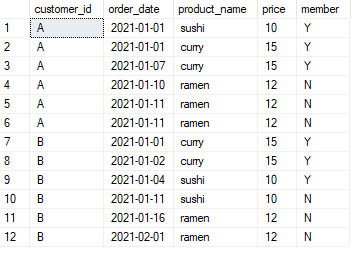

In [317]:
df = df_sales.merge(df_menu, on = 'product_id', how = 'left')
df = df.merge(df_members, on = 'customer_id', how = 'left')

In [318]:
df

,customer_id,order_date,product_id,product_name,price,join_date
0,A,2021-01-01,1,sushi,10,2021-01-07
1,A,2021-01-01,2,curry,15,2021-01-07
2,A,2021-01-07,2,curry,15,2021-01-07
3,A,2021-01-10,3,ramen,12,2021-01-07
4,A,2021-01-11,3,ramen,12,2021-01-07
5,A,2021-01-11,3,ramen,12,2021-01-07
6,B,2021-01-01,2,curry,15,2021-01-09
7,B,2021-01-02,2,curry,15,2021-01-09
8,B,2021-01-04,1,sushi,10,2021-01-09
9,B,2021-01-11,1,sushi,10,2021-01-09


In [319]:
df['member']=df['order_date']>=df['join_date']

In [320]:
def member(member):
    if member==True:
        return 'Y'
    else:
        return 'N'

In [323]:
df['member_2'] = df["member"].map(member)
df = df.drop(columns=['member','product_id','join_date'])

In [324]:
df

,customer_id,order_date,product_name,price,member_2
0,A,2021-01-01,sushi,10,N
1,A,2021-01-01,curry,15,N
2,A,2021-01-07,curry,15,Y
3,A,2021-01-10,ramen,12,Y
4,A,2021-01-11,ramen,12,Y
5,A,2021-01-11,ramen,12,Y
6,B,2021-01-01,curry,15,N
7,B,2021-01-02,curry,15,N
8,B,2021-01-04,sushi,10,N
9,B,2021-01-11,sushi,10,Y


## Bonus Questions

12. It is also requires further information about the ranking of customer products, but he purposely does not need the ranking for non-member purchases so he expects null ranking values for the records when customers are not yet part of the loyalty program.

In [334]:
df['ranking']=df[df['member_2']=='Y'].groupby(['customer_id'])['order_date'].rank(method='dense',ascending=True)    

In [335]:
df

,customer_id,order_date,product_name,price,member_2,ranking
0,A,2021-01-01,sushi,10,N,NaN
1,A,2021-01-01,curry,15,N,NaN
2,A,2021-01-07,curry,15,Y,1.0
3,A,2021-01-10,ramen,12,Y,2.0
4,A,2021-01-11,ramen,12,Y,3.0
5,A,2021-01-11,ramen,12,Y,3.0
6,B,2021-01-01,curry,15,N,NaN
7,B,2021-01-02,curry,15,N,NaN
8,B,2021-01-04,sushi,10,N,NaN
9,B,2021-01-11,sushi,10,Y,1.0
